# 0.0. Imports

In [1]:
import numpy  as np
import pandas as pd
import scikitplot as skplt

import pickle
import warnings
import random

import seaborn as sns
from boruta                import BorutaPy

from matplotlib import pyplot as plt

from pandas_profiling import ProfileReport

import xgboost           as xgb

from sklearn import metrics         as m

from sklearn.svm import SVC
from sklearn import model_selection as ms
from sklearn import linear_model    as lm
from sklearn import preprocessing   as pp
from sklearn import ensemble        as en
from sklearn import neighbors       as nh 
from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble      import RandomForestClassifier

from category_encoders import TargetEncoder



In C:\Users\ACER\anaconda3\envs\datasciencemproducao\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\ACER\anaconda3\envs\datasciencemproducao\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\ACER\anaconda3\envs\datasciencemproducao\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\ACER\anaconda3\envs\datasciencemproducao\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases

In [2]:
#!pip install scikit-plot

# 0.1. Helper Function

In [3]:
def warning_off():
    warnings.filterwarnings('ignore', category=FutureWarning) 
    pd.options.mode.chained_assignment = None
    
    return None
warning_off()

In [227]:
def data_preparation_yhat_model(target,x_val, y_val,model):
    # prepare dataset
    data = x_val.copy()
    data[target] = y_val.copy()
    
    # propensity score
    data['score'] = model[:, 1].tolist()      
    
    data = data.sort_values('score', ascending = False)
    
    # reset index
    data = data.reset_index( drop=True )
    
    return data



def precision_at_k( data, target, k=2000):
    

    # create ranking order
    data['ranking'] = data.index + 1 

    data['precision_at_k'] = data[target].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']


def recall_at_k(  data,target, k=2000 ):

    # create ranking order
    data['ranking'] = data.index + 1 

    data['recall_at_k'] = data[target].cumsum() / data[target].sum()

    return data.loc[k, 'recall_at_k']



def cross_validation(data,num_folds, model_name, model,target, k, x_train, y_train, verbose= False):
    
    for j in reversed( range( 1, num_folds+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( j ) )
    
        kfold = ms.StratifiedKFold(n_splits = num_folds, shuffle = True, random_state = 42)

        precision_list = []
        recall_list = []
        f1_score_list = []


        for train_cv,val_cv in kfold.split(x_train, y_train):

            x_train_fold = x_train.iloc[train_cv]
            y_train_fold = y_train.iloc[train_cv]

            x_val_fold = x_train.iloc[val_cv]
            y_val_fold = y_train.iloc[val_cv]

            model_fit = model.fit(x_train_fold,y_train_fold)

            yhat_model = model_fit.predict_proba(x_val_fold)

            x_val_fold[target] = y_val_fold
            
            dataset = data_preparation_yhat_model(target,x_val_fold.copy(), y_val_fold.copy(),yhat_model)
            precision = precision_at_k(dataset, target, k)
            precision_list.append(precision)

            recall = recall_at_k(dataset, target, k)
            recall_list.append(recall)

            f1_score = round(2*(precision * recall) / (precision + recall), 3)
            f1_score_list.append(f1_score)

        
        
    return pd.DataFrame( {'Model Name': model_name,
                          'PRECISION': np.round(np.mean(precision_list), 3).astype(str) + ' +/- ' + np.round(np.std(precision_list), 3).astype(str),
                          'RECALL': np.round( np.mean( recall_list ), 3 ).astype( str ) + ' +/- ' + np.round( np.std( recall_list ), 3 ).astype( str ),
                          'F1_score': np.round( np.mean( f1_score_list ), 3 ).astype( str ) + ' +/- ' + np.round( np.std( f1_score_list ), 3 ).astype( str ) }, index=[0] )
    
   

# 0.2. Load dataset

In [5]:
df_raw = pd.read_csv('../data/raw/train.csv')
df_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# 1.0. Data Description

In [6]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [7]:
#Lower case 
col_names = [name.lower() for name in df1.columns]

df1.columns = col_names
df1.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 1.2. Data Dimensions

In [8]:
print('Columns: ', df1.shape[1])
print('Rows: ',df1.shape[0])

Columns:  12
Rows:  381109


## 1.3. Data Types

In [9]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

### 1.3.1 Change Data Types

In [10]:
df1['region_code'] = df1['region_code'].astype( int)
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype( int )
df1['id'] = df1['id'].astype(np.int32)
df1['age'] = df1['age'].astype(np.int32)
df1['driving_license'] = df1['driving_license'].astype(np.int32)
df1['previously_insured'] = df1['previously_insured'].astype(np.int32)
df1['vintage'] = df1['vintage'].astype(np.int32)
df1['response'] = df1['response'].astype(np.int32)

df1.dtypes

id                        int32
gender                   object
age                       int32
driving_license           int32
region_code               int32
previously_insured        int32
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel      int32
vintage                   int32
response                  int32
dtype: object

## 1.4. Check NA

In [11]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.5. Data Descriptive

In [12]:
num_attributes = df1.select_dtypes(include= ['int32', 'float64'])
cat_attributes = df1.select_dtypes(exclude= ['int32', 'float64','datetime64[ns]'])


### 1.5.1. Numerical Attributes

In [13]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean )).T
ct2 = pd.DataFrame(num_attributes.apply(np.median )).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply( np.std)).T
d2 = pd.DataFrame(num_attributes.apply( min)).T
d3 = pd.DataFrame(num_attributes.apply( max)).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T

# concat
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


### 1.5.2. Categorical Attributes

In [14]:
cat_attributes.head()

,gender,vehicle_age,vehicle_damage
0,Male,> 2 Years,Yes
1,Male,1-2 Year,No
2,Male,> 2 Years,Yes
3,Male,< 1 Year,No
4,Female,< 1 Year,No


In [15]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

## 2.0. Hypothesis

**Business main questions:**

    - Customers : caracteristics of people who may be interested in hiring a car insurance 
    - Vehicle : What type of vehicle is more likely to be insurance (age, model, previously damaged)
    - Insurance Company: which of our customers are more likely to take out car insurance and witch chanel to use 

### 2.1 Customer Hypotheses

1. Older people ( more than 35 year old) are more likely to hire an insurance?
2. Women are more likely to contract an insurance than men?
3. The region where people live have some influency on hire or not and insurance?
4. Old people (over 70 years old) are not interested in car insurance ?
5. older customers of the insurance company are more likely to take out car insurance ?


### 2.2 Vehicle Hypotheses

1. People who have the vehicle damage previously are more likely to hire an insurance?
2. People don´t usually change car insurance company (fidelity) ? 
3. Newer vehicles are more insured ?

### 2.3 Company  Hypotheses

1. annual premium $30,0000 or more are more likely to take out insurance police
2. The more sales channel policy, more is the probability to response to an insurance proposal
3. ~~what is the most efficient channel ? ~~
4. ~~What channel is the cheapest, comparing to efficiency ?~~



# 3.0. Feature Engineering

## 3.1. Feature Engineering

In [16]:
df2 = df1.copy()
df2.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28,0,> 2 Years,Yes,40454.0,26,217,1
1,2,Male,76,1,3,0,1-2 Year,No,33536.0,26,183,0
2,3,Male,47,1,28,0,> 2 Years,Yes,38294.0,26,27,1
3,4,Male,21,1,11,1,< 1 Year,No,28619.0,152,203,0
4,5,Female,29,1,41,1,< 1 Year,No,27496.0,152,39,0


In [17]:
#vehicle_damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 0 if x == 'No' else 1)

#vehicle_age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 
                                              'between_1_2_year' if x == '1-2 Year' else 'below_1_year' )

df2.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28,0,over_2_years,1,40454.0,26,217,1
1,2,Male,76,1,3,0,between_1_2_year,0,33536.0,26,183,0
2,3,Male,47,1,28,0,over_2_years,1,38294.0,26,27,1
3,4,Male,21,1,11,1,below_1_year,0,28619.0,152,203,0
4,5,Female,29,1,41,1,below_1_year,0,27496.0,152,39,0


# 3.0. Data Filtering

In [18]:
df3 = df2.copy()

# 4.0. Exploratory Data Analysis (EDA)

In [19]:
df4 = df3.copy()

## 4.1. Univariate Analysis



### 4.1.1. Response Variable

- Response: many more negative (0) than positive(1) responses - commom for this kind of rearch
- Gender: df contains male (54%) female (46) - response yes (1) Female 4.77 % over Male 7.48 % **slightly difference**
- Age: (response = 1)  quartil 25%=	until 35 y     50%=	until 43y    75%= 	until 51
- driving_ license =  1: 99,8%  0: < 1%   (unbalanced data may cause bias)
- region_ code = region 28 is 27.9% of the df,  region 8 is 8,9%. Some reagion (5) are more willing to  hire an insurance than others( 1,64% median only). Region 28, even thought is the biggest one, they are more willing  to NOT hire an insurance.
- Previous insured = 99% of one condition, **may generate viés**
- vehicle_age - older vehicle are more insured 
- vehicle_damage - vehicle that had already been damaged are more likely to hire an insurance
- annual premium - median $31669, Q3 39.400 - very small difference from annual premium over 30.00 and response equal to 1 (3%) over annual premium less than 30.000
- policy sales channel - channel 26 more response 1
-vintage - no relation found to response ==1


In [20]:
# PROFILE  

#profile = ProfileReport( df4 )
#profile.to_file( 'output_v2.html' )

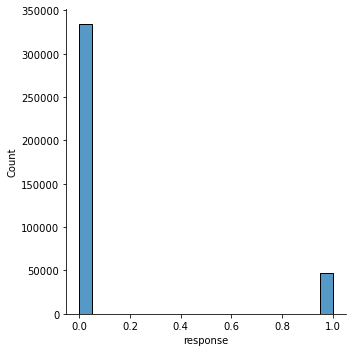

In [21]:
# analisar o label
sns.displot(df4['response'], kde=False);

In [22]:
df4.groupby(['response', 'region_code']).agg(quantity= ('id', 'count'), Age= ('age', 'median'),Premium=('annual_premium', 'mean'), Vintage=('vintage', 'mean')).sort_values('Premium').head(20)


quantity   Age       Premium     Vintage
response region_code                                          
0        1                 899  45.0   2660.351502  154.545050
         31               1763  43.0   2673.854793  158.567782
         48               4204  49.0   2677.646289  154.920314
         20               1712  47.0   2747.074766  152.521028
         0                1847  46.0   2863.350839  155.918787
1        48                477  47.0   2867.400419  155.542977
         31                197  44.0   2872.690355  149.609137
         20                223  45.0   3047.044843  159.430493
         1                 109  45.0   3131.376147  157.889908
         0                 174  48.0   5002.798851  159.310345
         44                 33  36.0  21089.515152  176.363636
         12                312  39.0  21878.336538  153.858974
         16                134  34.5  21915.417910  152.791045
         23                300  40.0  22702.416667  148.883333
0        27               2614  25.0  22811.244836  151.763198
         38               1637  44.0  23118.836286  156.795968
         16               1873  25.0  23143.487987  156.119060
1        3                1181  39.0  23189.732430  154.568163
         30                900  35.0  23218.614444  156.186667
         25                107  42.0  23259.392523  153.859813

### 4.1.2. Numerical Variable

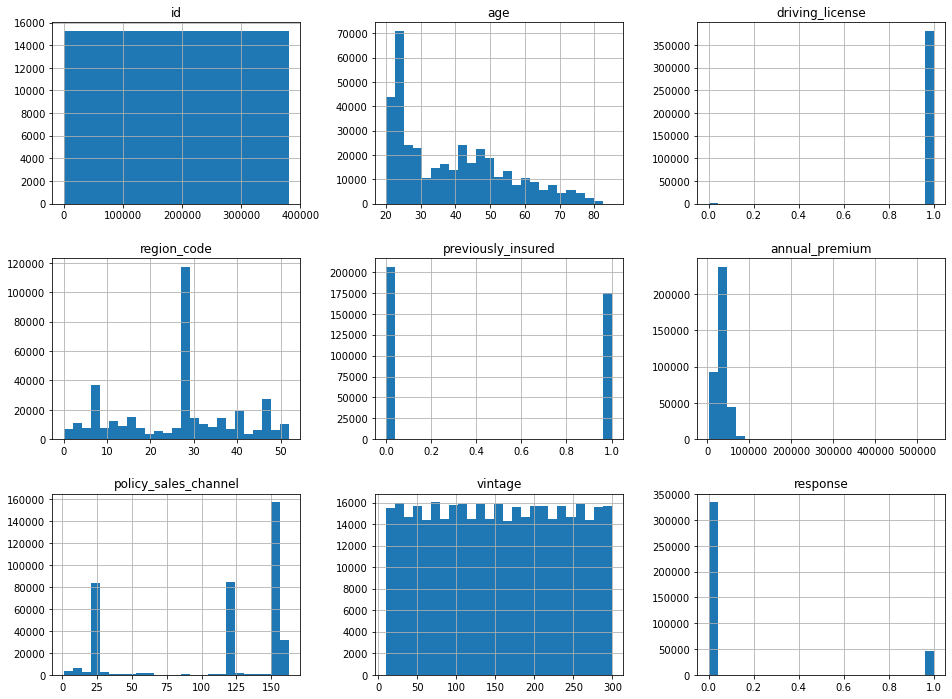

In [23]:
num_attributes.hist( bins=25, figsize= (16,12) );

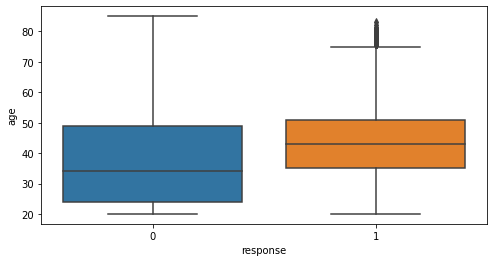

In [24]:
# Age
plt.subplots(figsize=(8, 4))
sns.boxplot( x='response', y='age', data=df4 );

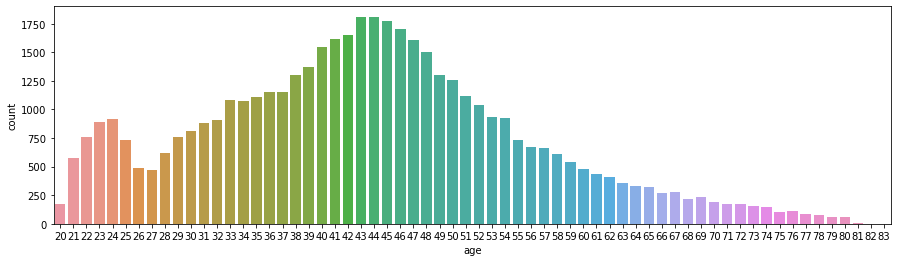

In [25]:
aux = df4[(df4['response'] == 1)]
fig = plt.subplots(figsize = (15,4))
sns.countplot(x = 'age', data = aux);

In [26]:
# Response = 1 
aux[['age']].describe()

,age
count,46710.000000
mean,43.435560
std,12.168924
min,20.000000
25%,35.000000
50%,43.000000
75%,51.000000
max,83.000000


In [27]:
# Response = 0 
aux0 = df4.loc[df4['response'] == 0, 'age']
aux0.describe()

count    334399.000000
mean         38.178227
std          15.816052
min          20.000000
25%          24.000000
50%          34.000000
75%          49.000000
max          85.000000
Name: age, dtype: float64

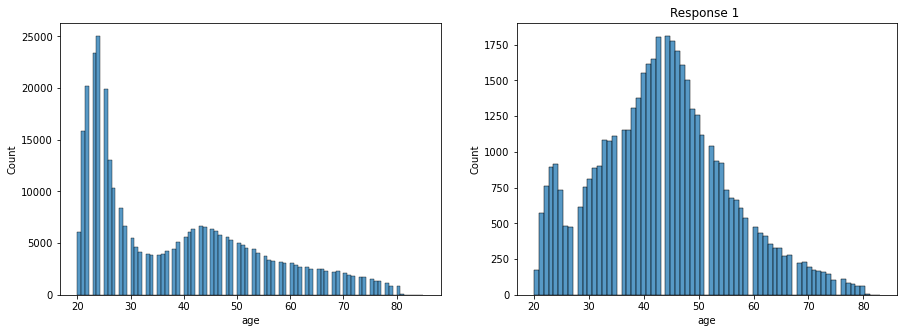

In [28]:
fig, axs = plt.subplots(ncols= 2, figsize = (15,5))
aux00 = df4.loc[df4['response'] == 0, 'age']
sns.histplot( aux00, ax = axs[0] )


aux1 = df4.loc[df4['response'] == 1, 'age']
sns.histplot( aux1, ax = axs[1]  );
plt.title('Response 1 ');

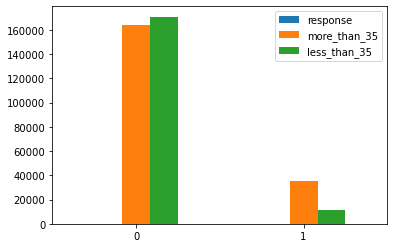

In [29]:
more_equal_35 =df4.loc[(df4['age'] >= 35),:].groupby('response').count()['age'].reset_index().rename(columns={"response": "response", "age": "more_than_35"})
less_than_35 = df4.loc[(df4['age'] < 35),:].groupby('response').count()['age'].reset_index()
less_than_35.columns= ['response', 'less_than_35']
age_aux = more_equal_35.merge(less_than_35, how='left', on='response')
age_aux.plot.bar(rot=0);

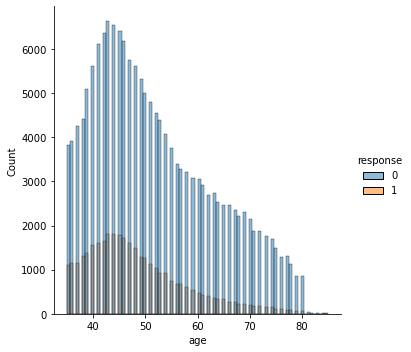

In [30]:
aux = df4.loc[df4['age'] >= 35, :]
sns.displot(x= 'age',hue="response", data= aux);

In [31]:
more_equal_70 =df4.loc[(df4['age'] >= 70),:].groupby('response').count()['age'].reset_index().rename(columns={"response": "response", "age": "more_than_70"})
less_than_70 = df4.loc[(df4['age'] < 70),:].groupby('response').count()['age'].reset_index()
less_than_70.columns= ['response', 'less_than_70']
age_aux = more_equal_70.merge(less_than_70, how='left', on='response')


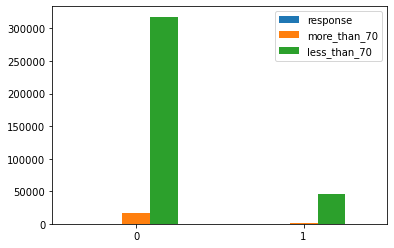

In [32]:
age_aux.plot.bar(rot=0);

In [33]:
age_aux

,response,more_than_70,less_than_70
0,0,16411,317988
1,1,1339,45371


In [34]:
more_70 = df4.loc[df4['age'] >= 70, :]
more_70.groupby(['response']).agg(Percentage=('age', 'sum')).apply(lambda x: np.round(100 * x / float(x.sum()),2))

,Percentage
response,
0,92.49
1,7.51


1. Older people ( more than 35 year old) are more likely to hire an insurance?
**Yes, but the interest decreases after a certain age( 50th´s)**

4. Old people (over 70 years old) are not interested in car insurance ?
**YES, people older than 70 years old are NOT interested in car insurance**

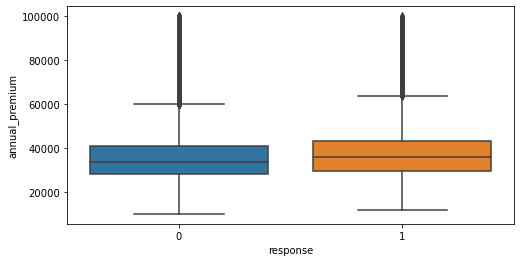

In [67]:
# Annul income
plt.subplots(figsize=(8, 4))
sns.boxplot(x='response', y='annual_premium', data=df4);

- too many outliers, try to zoon it

In [66]:
df4 = df4[(df4['annual_premium'] > 10000) &(df4['annual_premium'] < 100000)]

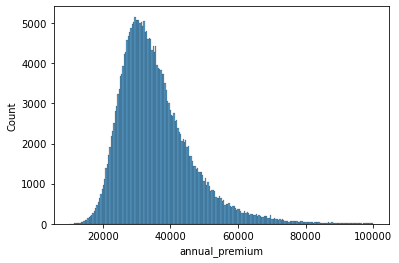

In [68]:
aux00 = df4.loc[df4['response'] == 0, 'annual_premium']
sns.histplot( aux00 );

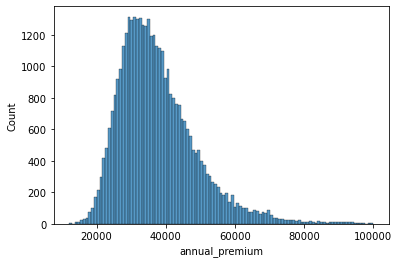

In [69]:
aux00 = df4.loc[df4['response'] == 1, 'annual_premium']
sns.histplot( aux00 );

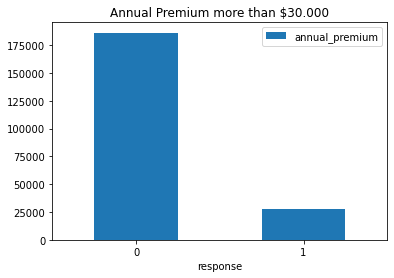

In [70]:
aux = df4.loc[(df4['annual_premium'] >= 30000), :]
axes =aux.groupby('response').count()['annual_premium'].plot.bar(rot=0, subplots=True);
axes[0].legend(loc=1)
plt.title('Annual Premium more than $30.000');

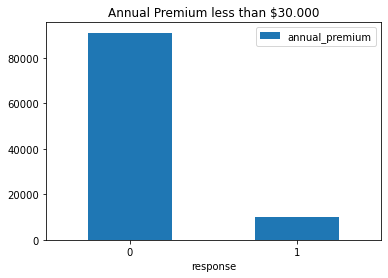

In [71]:
aux2= df4.loc[(df4['annual_premium'] < 30000), :]
axes =aux2.groupby('response').count()['annual_premium'].plot.bar(rot=0, subplots=True);
axes[0].legend(loc=1)
plt.title('Annual Premium less than $30.000');

In [80]:
percent_more= aux.groupby('response').count()['annual_premium'].reset_index()
soma= percent_more['annual_premium'].sum()
percent_more['percent'] = percent_more['annual_premium'].apply(lambda x: np.round(x/soma, 2) )
percent_more


,response,annual_premium,percent
0,0,186213,0.87
1,1,28053,0.13


In [83]:
percent_less= aux2.groupby('response').count()['annual_premium'].reset_index()
soma_less= percent_less['annual_premium'].sum()
percent_less['percent'] = percent_less['annual_premium'].apply(lambda x: np.round(x/soma_less,2 ) )
percent_less

,response,annual_premium,percent
0,0,91155,0.9
1,1,10028,0.1


2. annual premium $30.000 or more are more likely to take out insurance

    Too many ouliers- solution: annual_premium greater than 10.000 and lower than 100000

   **YES, BUT less than 0,03 difference between them**

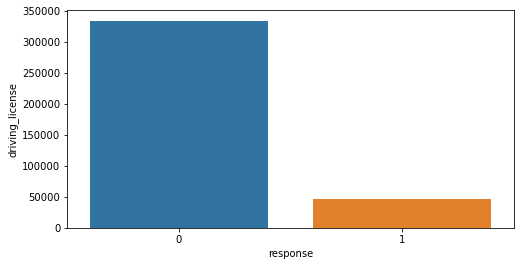

In [35]:
# driving license
plt.subplots(figsize=(8, 4))
aux = df4[['driving_license', 'response']].groupby( 'response' ).sum().reset_index()
sns.barplot( x='response', y='driving_license', data=aux );


<AxesSubplot:xlabel='region_code', ylabel='id'>

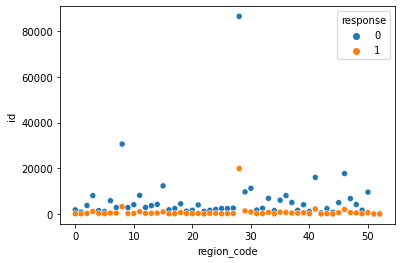

In [36]:
# region code
aux0 = df4[['id', 'region_code', 'response']].groupby( ['region_code', 'response'] ).count().reset_index()
sns.scatterplot( x='region_code', y='id', hue='response', data=aux0 )


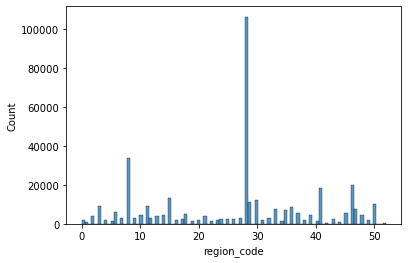

In [37]:
sns.histplot(df4['region_code']);

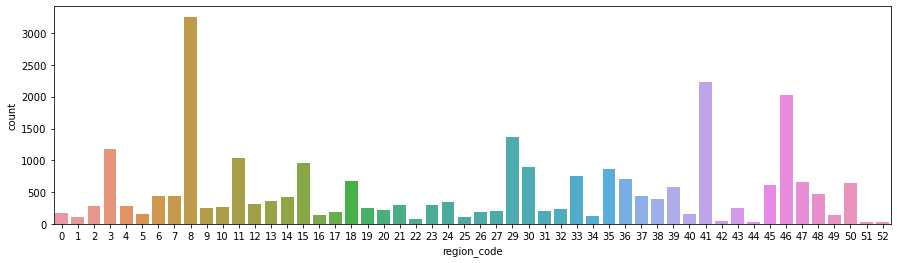

In [38]:
aux = df4[(df4['region_code'] != 28) & (df4['response'] == 1)]
fig = plt.subplots(figsize = (15,4))
sns.countplot(x = 'region_code', data = aux);

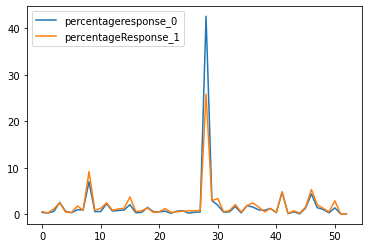

In [39]:
aux_region_1 = df4.loc[df4['response'] == 1, :].groupby([ 'region_code']).agg(Regiao= ('region_code', 'count')).reset_index()

perc_region_code_yes =aux_region_1[['Regiao']].apply(lambda x: np.round(100 * x / float(x.sum()),2)).reset_index()
perc_region_code_yes.columns = ['region_code', 'percentage']


aux_region_0 = df4.loc[df4['response'] == 0, :].groupby([ 'region_code']).agg(Regiao= ('region_code', 'count')).reset_index()

perc_region_code_no = aux_region_0[['Regiao']].apply(lambda x: np.round(100 * x / float(x.sum()),2)).reset_index()
perc_region_code_no.columns=['region_code', 'percentage']



m =pd.merge(perc_region_code_yes, perc_region_code_no, how='left', on='region_code', suffixes=('response_0', 'Response_1') )
m['dif'] = abs(m['percentageresponse_0'] - m['percentageResponse_1'])

m[['percentageresponse_0', 'percentageResponse_1']].plot();


In [40]:
m['dif'] = abs(m['percentageresponse_0'] - m['percentageResponse_1'])
#m.style.highlight_max( color='lightgreen', axis=0, subset=['dif'] )
m.loc[m['dif'] >= 1, :]

,region_code,percentageresponse_0,percentageResponse_1,dif
8,8,6.97,9.16,2.19
15,15,2.05,3.69,1.64
28,28,42.64,25.87,16.77
30,30,1.93,3.38,1.45
50,50,1.37,2.87,1.50


3. The region where people live have some influency on hiring or not an insurance?
**YES, but there are only  5 regions where it´s possible to valuate a predisposition based on the region_code and it differs (median) only 1,64 %, except from region 28 where the diference on percental are 26,77% more on response 0 over response 1**

In [41]:
#region 28 represents 27.9% of the database
df4.loc[df4['region_code'] == 28, :].groupby([  'response']).agg(quantity= ('id', 'count'),Age= ('age', 'median'),Premium=('annual_premium', 'median'), Vintage=('vintage', 'median')).sort_values('Premium')


,quantity,Age,Premium,Vintage
response,,,,
0,86498,45,38584.0,154
1,19917,45,39138.0,155


In [43]:
# region 8 
df4.loc[df4['region_code'] == 8, :].groupby([  'response']).agg(quantity= ('id', 'count'),Age= ('age', 'median'),Premium=('annual_premium', 'median'), Vintage=('vintage', 'median')).sort_values('Premium')


,quantity,Age,Premium,Vintage
response,,,,
1,3257,45,36604.0,151
0,30620,33,37263.5,155


In [48]:
df4.loc[df4['region_code'] == 15, :].groupby([  'response']).agg(quantity= ('id', 'count'),Age= ('age', 'median'),Premium=('annual_premium', 'median'), Vintage=('vintage', 'median')).sort_values('Premium')


,quantity,Age,Premium,Vintage
response,,,,
1,958,39,31362.0,159
0,12350,26,31971.5,156


In [50]:
# Previous insured
pd.crosstab(df4['previously_insured'], df4['response'] ).apply( lambda x: x / x.sum(), axis=1 )

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


- 99% of one condition, may generate viés 

In [63]:
df4['vehicle_damage'].unique()

array([1, 0], dtype=int64)

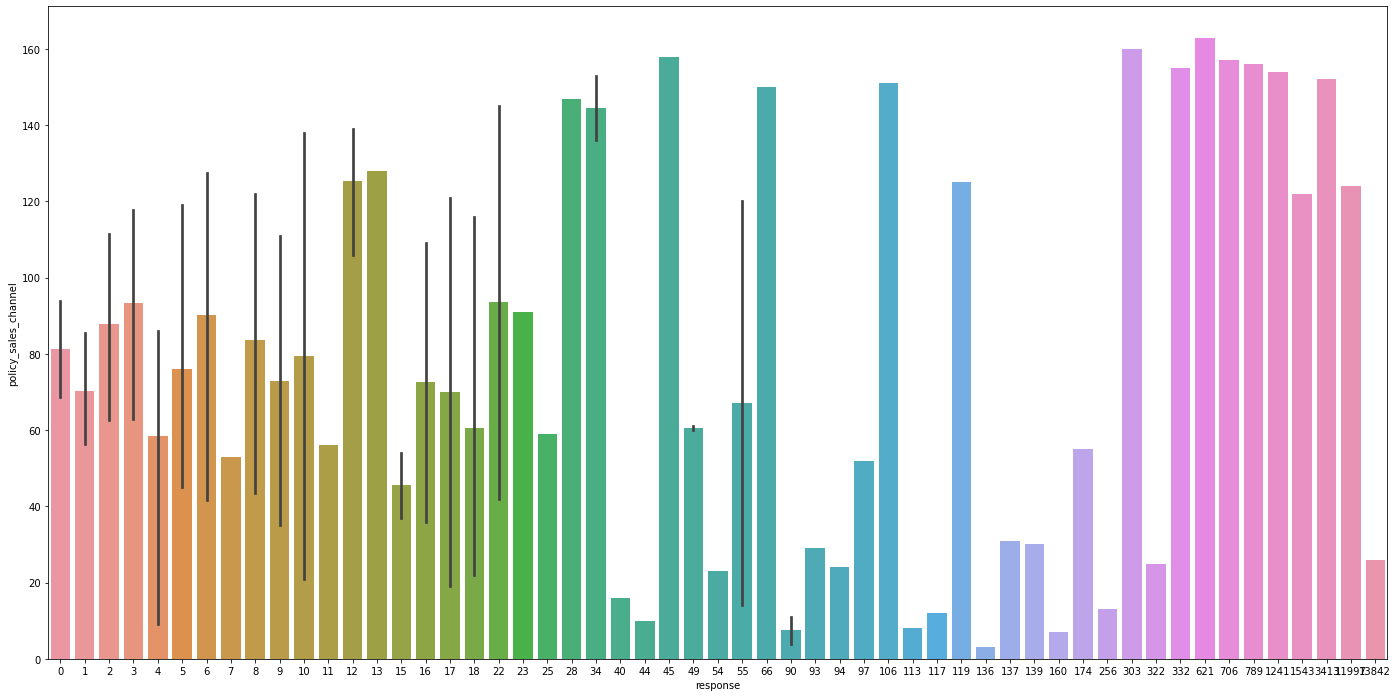

In [98]:
#'policy_sales_channel'
plt.figure( figsize=(24, 12 ))
aux = df4[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel').sum().reset_index()
sns.barplot( x='response', y='policy_sales_channel', data=aux );

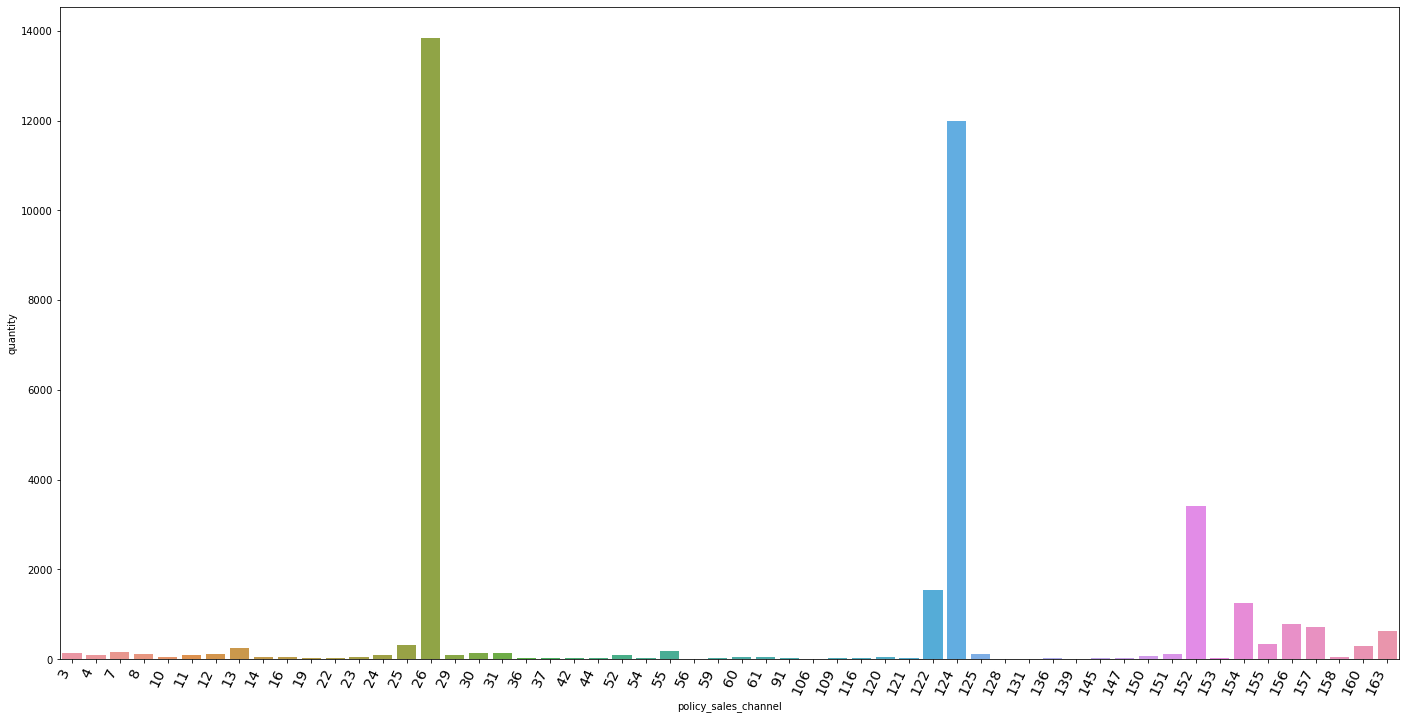

In [131]:
plt.figure( figsize=(24, 12 ))
ax =df4.groupby([  'response', 'policy_sales_channel']).agg(quantity= ('id', 'count')).reset_index()
a= ax.loc[(ax['response']==1)& (ax['quantity']> 10)]
sns.barplot(  x='policy_sales_channel',y='quantity', data=a );
plt.xticks(
    rotation=65, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
);


3. The more sales channel, more is the probability to response to an insurance proposal

    **NO**

In [139]:
df4.loc[(df4['policy_sales_channel'] == 26), :].groupby([  'response', 'region_code']).agg(quantity= ('id', 'count'),Age= ('age', 'median'),Premium=('annual_premium', 'median'), Vintage=('vintage', 'median')).sort_values('quantity', ascending= False).head(20)

quantity   Age  Premium  Vintage
response region_code                                  
0        28              26606  50.0  40513.5    154.0
1        28               8210  48.0  41733.5    157.0
0        8                4833  51.0  39476.0    154.0
         46               2302  50.0  30464.0    157.0
         41               2086  50.0  34312.5    153.5
         29               1278  50.0  34733.0    153.0
         3                1059  51.0  30531.0    158.0
1        8                 932  48.0  39744.5    148.0
0        47                882  46.0  33400.5    155.0
         33                848  52.0  33210.5    154.0
         15                830  48.0  34779.5    149.0
         11                773  52.0  31871.0    149.0
         50                723  51.0  34309.0    153.0
         45                696  49.0  29920.5    145.5
         39                677  53.0  34379.0    161.0
         30                655  48.0  30098.0    152.0
         36                589  47.0  34556.0    148.0
         35                578  49.0  32747.0    154.0
1        41                542  47.0  34755.5    154.0
0        14                508  48.0  30740.0    154.5

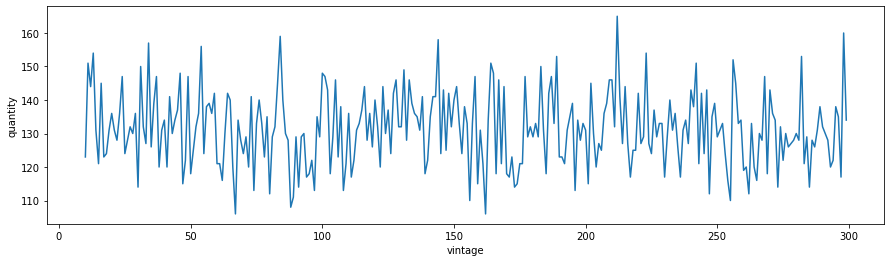

In [165]:
# Vintage
ax = df4.groupby([  'response', 'vintage']).agg(quantity= ('id', 'count')).reset_index()
a= ax.loc[(ax['response'] ==1)]
fig = plt.subplots(figsize = (15,4))
sns.lineplot(  x='vintage',y='quantity', data=a );


5. older customers of the insurance company are more likely to hire car insurance ?
**No, there is no relation**

### 4.1.3. Categorical Variable

<AxesSubplot:xlabel='vehicle_age', ylabel='count'>

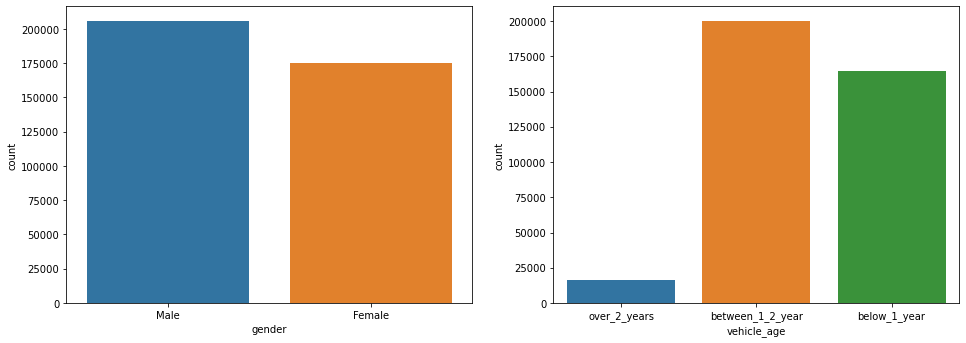

In [51]:
#gender vehicle_age vehicle_damage

plt.figure( figsize=(16, 12 ))
# Gender

plt.subplot( 2, 2, 1 )
sns.countplot( df4['gender'] );

plt.subplot( 2, 2, 2 )

# Vehicle_age

sns.countplot( df4['vehicle_age'] )





In [50]:
df4.groupby(['response', 'gender']).agg(Percentage=('gender', 'count')).apply(lambda x: np.round(100 * x / float(x.sum()),2))

Percentage
response gender            
0        Female       41.15
         Male         46.59
1        Female        4.77
         Male          7.48

4. Women are more likely to contract an insurance than men?

    **NO, men are more likely**


In [62]:
# vehicle_age

pd.crosstab(df4['vehicle_age'], df4['response'] ).apply( lambda x: np.round(x / x.sum(), 2), axis=1 )

response,0,1
vehicle_age,,
below_1_year,0.96,0.04
between_1_2_year,0.83,0.17
over_2_years,0.71,0.29


Newer vehicles are more insured ?

**NO, vehicle over 2 years are more insurance**


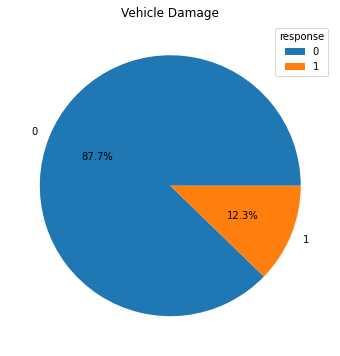

In [64]:
plt.figure( figsize=(10, 6 ))

# vehicle damage
a=df4.groupby('response').count()[['vehicle_damage']].reset_index()
plt.pie(a['vehicle_damage'], labels =a['response'], autopct="%.1f%%");
plt.legend(title = "response");
plt.title('Vehicle Damage');



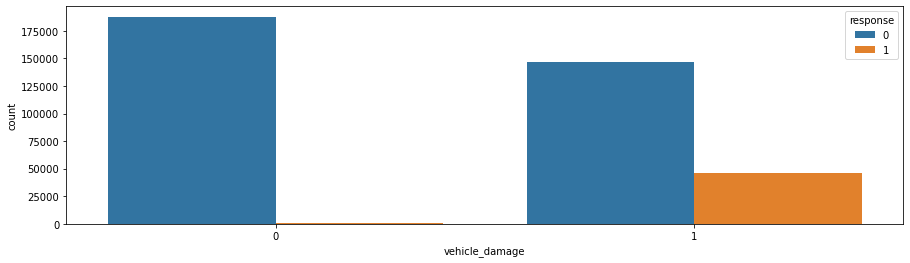

In [65]:
fig, axs = plt.subplots(figsize = (15,4))
sns.countplot(x = df4['vehicle_damage'], hue = df4['response']);

5. People who have the vehicle damage are more likely to hire an insurance?

    **Yes, comparing to people who has never had the veiche damaged**

# 5.0. Data Preparation

In [166]:
df5 = df4.copy()

In [167]:
X = df4.drop( 'response', axis=1 )
y = df4['response'].copy() 

x_train, x_validation, y_train, y_validation = ms.train_test_split( X, y, test_size=0.20 )

df5 = pd.concat( [x_train, y_train], axis=1 )

## 5.1. Standardization

In [168]:
ss = pp.StandardScaler()

# annual_premium
df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values )

## 5.2. Rescaling

In [169]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age
df5['age'] = mms_age.fit_transform( df5[['age']].values )

# vintage
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values )

### 5.3.1. Encoding

## Encoder

In [170]:
# gender - One Hot Encoding / Target Encoding

encoder_gender =TargetEncoder()
df5['gender'] = encoder_gender.fit_transform(df5['gender'], df5['response'])

# region_code - Target Encoding / Frequency Encoding
target_encode_region_code = df5.groupby( 'region_code' )['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )


## vehicle_age - One Hot Encoding / Frequency Encoding
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

## policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 ) 
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )

## 5.4. Validation Preparation

In [171]:
# gender
x_validation.loc[:, 'gender'] =  encoder_gender.transform(x_validation[['gender']], y=None )

# age
x_validation.loc[:, 'age'] = mms_age.transform( x_validation[['age']].values )

# region_code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map( target_encode_region_code )

# vehicle_age
x_validation = pd.get_dummies( x_validation, prefix='vehicle_age', columns=['vehicle_age'] )

# annual_premium
x_validation.loc[:, 'annual_premium'] = ss.transform( x_validation[['annual_premium']].values )

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map( fe_policy_sales_channel )

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.transform( x_validation[['vintage']].values )

# fillna
x_validation = x_validation.fillna( 0 )

In [172]:
df5.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,vehicle_age_below_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years
162893,162894,0.099974,0.538462,1,0.092499,0,1,-0.339994,0.195892,0.595156,0,0,1,0
362436,362437,0.138219,0.584615,1,0.188085,0,1,2.572906,0.212962,0.207612,0,0,0,1
80776,80777,0.138219,0.353846,1,0.068541,0,1,-0.476134,0.195892,0.359862,0,0,1,0
330088,330089,0.099974,0.015385,1,0.188085,1,0,-0.591980,0.387068,0.602076,0,1,0,0
372605,372606,0.138219,0.046154,1,0.066323,0,1,0.881624,0.387068,0.802768,0,1,0,0


# 6.0. Feature Selection

In [173]:
df6 = df5.copy()

## 6.1. Boruta Algorithm

In [ ]:
## training and test dataset for Boruta
#x_train_b = df6.drop(['id', 'response'], axis = 1).values
#y_train_b = y_train.values.ravel()
#
#
## define RandomForestRegressor
#rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
#
## define Boruta feature selection method
#boruta_feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit( x_train_b,y_train_b )
#
## find all relevant features
#boruta_feat_selector.fit(x_train_b,y_train_b )
#
## check ranking of features
#boruta_feat_selector.ranking_

In [ ]:
#cols_selected = boruta_feat_selector.support_.tolist()
#
##colunas selecionadas
#x_train_fs = df6.drop(['id', 'response'], axis = 1)
#cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()
#
##colunas não selecionadas
#cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns,cols_selected_boruta))
#
#print("BorutaSelected Column: \n",cols_selected_boruta )
#
#
#print("Boruta NOT Selected Column:", cols_not_selected_boruta )


## 6.2. Feature Importance

In [174]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
x_train_n = df5.drop( ['id', 'response'], axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=-1,
                     oob_score=False, random_state=0, verbose=0,
                     warm_start=False)

feature ranking
                        feature  importance
0                annual_premium    0.274667
0                       vintage    0.249203
0                           age    0.155158
0                   region_code    0.101760
0                vehicle_damage    0.072382
0          policy_sales_channel    0.058304
0            previously_insured    0.057397
0      vehicle_age_below_1_year    0.016145
0  vehicle_age_between_1_2_year    0.006643
0                        gender    0.004764
0      vehicle_age_over_2_years    0.003060
0               driving_license    0.000517


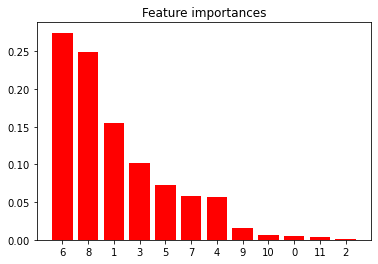

In [175]:
importances = forest.feature_importances_
indices = np.argsort( importances )[::-1]

print( 'feature ranking')
df = pd.DataFrame()

for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

Selected Columns :

From EDA Analysis:
    
            'gender','age','region_code','annual_preminum','vehicle_age_over_2_years',
            'vehicle_damage','policy_sales_channel'
         
From Boruta
       
         'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_damage', 'annual_premium', 
         'policy_sales_channel', 'vehicle_age_below_1_year', 'vehicle_age_between_1_2_year', 'vehicle_age_over_2_years'
    

From Features Importance - untill 5% 

        'annual_premium', 'vintage', 'age', 'region_code','vehicle_damage', 'policy_sales_channel', 'previously_insured'.        
Features final list:
        'gender','age','region_code','annual_premium', 'vehicle_damage', 'policy_sales_channel', 'vehicle_age_over_2_years'

# 7.0. Machine Learning Modelling

In [176]:
df7 = df6.copy()

In [202]:
column_selected = ['gender','age','region_code','annual_premium', 'vehicle_damage', 'policy_sales_channel', 'vehicle_age_below_1_year', 'vehicle_age_over_2_years', 'vehicle_age_between_1_2_year']

X_train = df7[column_selected]
x_test= x_validation[column_selected]
y_test = y_validation.copy()

- **Ordering Metrics**

## 7.1. KNN Classifier

In [209]:
import pickle
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=7 )

# model training
knn_model.fit( X_train, y_train )
pickle.dump(knn_model, open('../model/knn_model-02.pkl', 'wb'))
#knn_model = pickle.load(open('../model/knn_model.pkl', 'rb'))
# model prediction - Poder de GENERALIZACAO 
yhat_knn = knn_model.predict_proba( x_test )


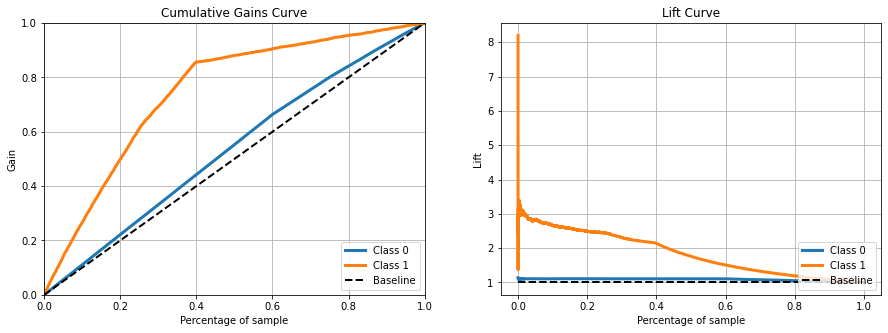

In [210]:
fig, axs = plt.subplots(ncols= 2, figsize = (15,5))
skplt.metrics.plot_cumulative_gain(y_test, yhat_knn, ax=axs[0])
skplt.metrics.plot_lift_curve(y_test, yhat_knn,ax=axs[1]);

## 7.2. Logistic Regression

In [203]:
# model definition
lr_model = lm.LogisticRegression( random_state=42 ) 

# model training
lr_model.fit( X_train, y_train )
pickle.dump(lr_model, open('../model/lr_model_02.pkl', 'wb'))
#lr_model = pickle.load(open('../model/lr_model.pkl', 'rb'))

# model prediction
yhat_lr = lr_model.predict_proba( x_test )

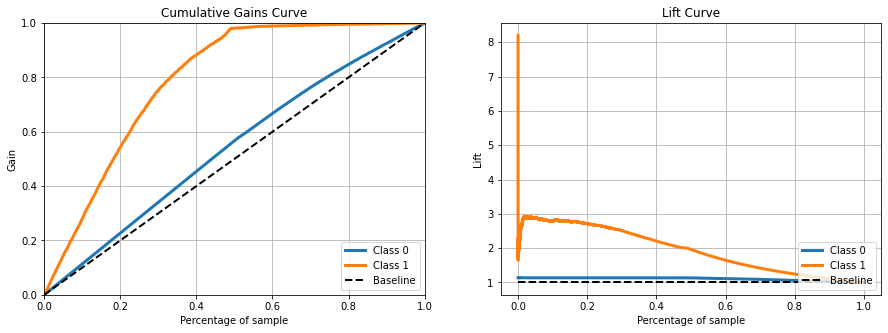

In [204]:
fig, axs = plt.subplots(ncols= 2, figsize = (15,5))
skplt.metrics.plot_cumulative_gain(y_test, yhat_lr, ax=axs[0])
skplt.metrics.plot_lift_curve(y_test, yhat_lr,ax=axs[1]);

## 7.3. RandomForest Classifier

In [207]:
# model definition
rfc_model = RandomForestClassifier(n_estimators = 300, random_state = 42)

# model fit
rfc_model.fit( X_train, y_train )
pickle.dump(rfc_model, open('../model/rfc_model-02.pkl', 'wb'))
#rfc_model = pickle.load(open('../model/rfc_model.pkl', 'rb'))

# model predict
yhat_rfc = rfc_model.predict_proba( x_test )



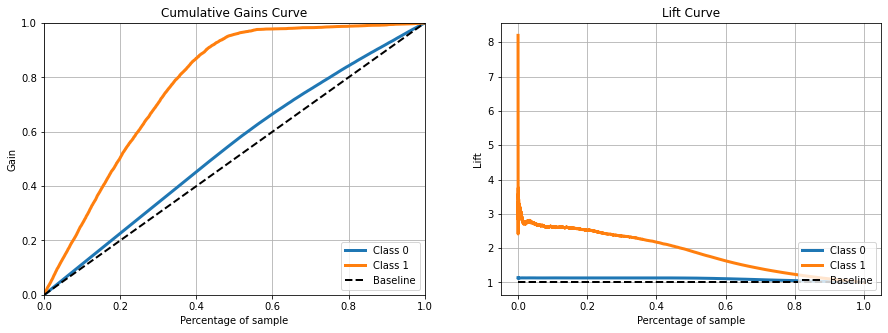

In [208]:
fig, axs = plt.subplots(ncols= 2, figsize = (15,5))
skplt.metrics.plot_cumulative_gain(y_test, yhat_rfc, ax=axs[0])
skplt.metrics.plot_lift_curve(y_test, yhat_rfc,ax=axs[1]);

## 7.4. Naive Bayles

In [211]:
# model definition
naive_model = GaussianNB()

# model fit
naive_model.fit( X_train, y_train )
pickle.dump(naive_model, open('../model/naive_model_02.pkl', 'wb'))
#naive_model = pickle.load(open('../model/naive_model_02.pkl', 'rb'))

# model predict
yhat_naive = naive_model.predict_proba( x_test )

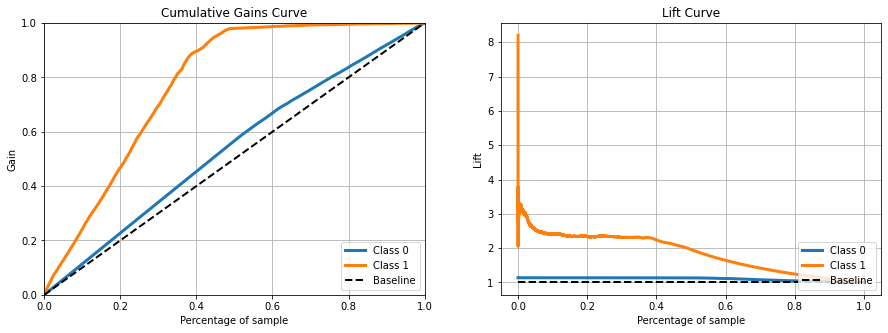

In [212]:
fig, axs = plt.subplots(ncols=2, figsize= (15,5))
skplt.metrics.plot_cumulative_gain(y_test, yhat_naive, ax=axs[0])
skplt.metrics.plot_lift_curve(y_test, yhat_naive,ax=axs[1]);

## 7.5. XGBoost Classifier

In [213]:
# model definition
xgb_model = xgb.XGBClassifier(objective = 'binary:logistic', eval_metric = 'error')

# model fit
model_xgb = xgb_model.fit(X_train,y_train)
pickle.dump(model_xgb, open('../model/model_xgbl_02.pkl', 'wb'))
#model_xgb = pickle.load(open('../model/model_xgbl.pkl', 'rb'))

# model predict
yhat_xgb = model_xgb.predict_proba(x_test)

pd.DataFrame({'Variable':X_train.columns,
              'Importance':model_xgb.feature_importances_}).sort_values('Importance', ascending=False)

,Variable,Importance
4,vehicle_damage,0.883088
1,age,0.043238
2,region_code,0.018461
5,policy_sales_channel,0.014391
6,vehicle_age_below_1_year,0.013376
7,vehicle_age_over_2_years,0.010925
8,vehicle_age_between_1_2_year,0.006949
0,gender,0.006679
3,annual_premium,0.002894


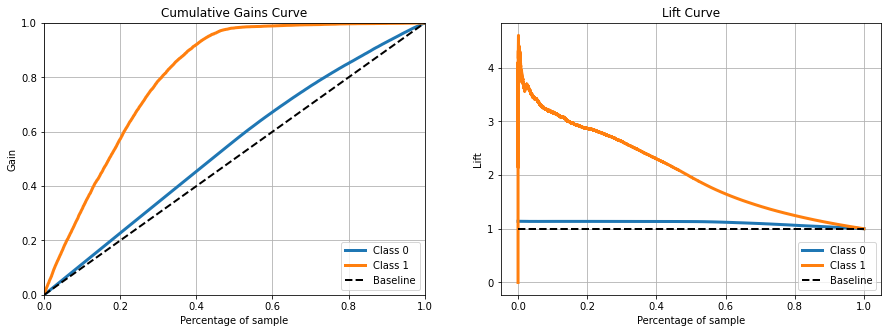

In [214]:
fig, axs = plt.subplots(ncols=2, figsize= (15,5))
skplt.metrics.plot_cumulative_gain(y_test, yhat_xgb, ax=axs[0])
skplt.metrics.plot_lift_curve(y_test, yhat_xgb,ax=axs[1]);

## 8.0. Performance Metrics

In [215]:
df8 = df7.copy()

In [216]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = model_xgb.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[55398     0]
 [ 7692     0]]


0.8780789348549691

## 8.1 Single performance

In [217]:
df8_xgb = data_preparation_yhat_model('response',x_validation.copy(),y_validation.copy(), yhat_xgb )
df8_xgb.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,vehicle_age_below_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years,response,score
0,285853,0.138219,0.276923,1,0.188085,0,1,1.581160,0.212962,0.110727,0,0,1,0,0.499400
1,26464,0.138219,0.184615,1,0.116494,0,1,-0.839871,0.212962,0.948097,0,0,1,1,0.481924
2,238243,0.138219,0.246154,1,0.188085,0,1,0.129124,0.212962,0.456747,0,0,1,0,0.480903
3,190709,0.138219,0.246154,1,0.188085,0,1,-0.338174,0.212962,0.183391,0,0,1,0,0.480903
4,1901,0.138219,0.276923,1,0.188085,0,1,0.735110,0.212962,0.301038,0,0,1,0,0.478862


In [218]:
# Knn
df8_knn = data_preparation_yhat_model('response',x_validation.copy(),y_validation.copy(), yhat_knn )
# compute precision at k
knn_precision = precision_at_k( df8_knn,'response', k=15000 )
# Recall @k
knn_recall = recall_at_k( df8_knn, 'response' , k=15000 )

print( 'Precision at K: {}, Recall : {}'.format(knn_precision, knn_recall ) )

Precision at K: 0.29838010799280046, Recall : 0.5819032761310452


In [219]:
# Logistic Regression
df8_lr = data_preparation_yhat_model('response',x_validation.copy(),y_validation.copy(), yhat_lr )
# compute precision at k
lr_precision = precision_at_k( df8_lr,'response', k=15000 )
# Recall @k
lr_recall = recall_at_k( df8_lr, 'response' , k=15000 )

print( 'Precision at K: {}, Recall : {}'.format(lr_precision, lr_recall ) )

Precision at K: 0.32331177921471904, Recall : 0.6305252210088403


In [220]:
# Naive Bayes
df8_bayes = data_preparation_yhat_model('response',x_validation.copy(),y_validation.copy(), yhat_naive )
# compute precision at k
naive_precision = precision_at_k( df8_bayes,'response', k=15000 )
# Recall @k
naive_recall = recall_at_k( df8_bayes, 'response' , k=15000 )

print( 'Precision at K: {}, Recall : {}'.format(naive_precision, naive_recall ) )

Precision at K: 0.2867142190520632, Recall : 0.5591523660946438


In [221]:
# Random Forest Classifier
df8_rfc = data_preparation_yhat_model('response',x_validation.copy(),y_validation.copy(), yhat_rfc )
# compute precision at k
rfc_precision = precision_at_k( df8_rfc,'response', k=15000 )
# Recall @k
rfc_recall = recall_at_k( df8_rfc, 'response' , k=15000 )

print( 'Precision at K: {}, Recall : {}'.format(rfc_precision, rfc_recall ) )

Precision at K: 0.29924671688554094, Recall : 0.5835933437337494


In [222]:
#Xgboost 
df8_xgb = data_preparation_yhat_model('response',x_validation.copy(),y_validation.copy(), yhat_xgb )
xgb_precision = precision_at_k( df8_xgb,'response', k=15000 )
# Recall at K
xgb_recall = recall_at_k( df8_xgb, 'response' , k=15000 )
print( 'Precision at K: {}, Recall : {}'.format(xgb_precision, xgb_recall ) )

Precision at K: 0.3403773081794547, Recall : 0.6638065522620905


## 8.2. Compare Model's Performance

In [223]:
performance_summary = { 
    'Precision at K' : [lr_precision, naive_precision, knn_precision, rfc_precision, xgb_precision],
    'Recall at K'    : [lr_recall, naive_recall, knn_recall, rfc_recall, xgb_recall]
}

metrics = pd.DataFrame(performance_summary).T
metrics.columns = ['Logistic R', 'Naive Bayes', 'KNN', 'Randon F', 'XGBoosting']
metrics.style.highlight_max( color='lightgreen', axis=1 )

,Logistic R,Naive Bayes,KNN,Randon F,XGBoosting
Precision at K,0.323312,0.286714,0.298380,0.299247,0.340377
Recall at K,0.630525,0.559152,0.581903,0.583593,0.663807


In [ ]:
cv_performance_lr = cross_validation (df8,5, 'Logic Regression', lr_model,'response',15000 ,X_train, y_train, verbose= True)

In [224]:
cv_performance_bayes = cross_validation (df8,5, 'Naive Bayes', naive_model,'response',15000 ,X_train, y_train, verbose= True)


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


In [225]:
cv_performance_bayes

,Model Name,PRECISION,RECALL,F1_score
0,Naive Bayes,0.283 +/- 0.001,0.697 +/- 0.004,0.402 +/- 0.002


In [231]:
cv_performance_Knn = cross_validation (df8,5, 'KNN', knn_model,'response',15000 ,X_train, y_train, verbose= True)
cv_performance_Knn


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


NameError: name 'cv_performanmce_Knn' is not defined

In [232]:
cv_performance_Knn

,Model Name,PRECISION,RECALL,F1_score
0,KNN,0.281 +/- 0.003,0.694 +/- 0.008,0.4 +/- 0.004


In [233]:
cv_performance_rfc = cross_validation (df8,5, 'Randon Forest Classifier', rfc_model,'response',15000 ,X_train, y_train, verbose= True)
cv_performance_xgb= cross_validation (df8,5, 'XG Boosting', xgb_model,'response',15000 ,X_train, y_train, verbose= True)


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


In [234]:
cross_validation =pd.concat([cv_performance_Knn,cv_performance_rfc,cv_performance_xgb ,cv_performance_bayes], ignore_index=True)
cross_validation.to_csv('../data/cross_validation_02.csv', index= False)


In [235]:
cross_validation = pd.read_csv('../data/cross_validation_02.csv')
cross_validation

,Model Name,PRECISION,RECALL,F1_score
0,KNN,0.281 +/- 0.003,0.694 +/- 0.008,0.4 +/- 0.004
1,Randon Forest Classifier,0.286 +/- 0.002,0.705 +/- 0.006,0.407 +/- 0.003
2,XG Boosting,0.318 +/- 0.002,0.785 +/- 0.005,0.453 +/- 0.003
3,Naive Bayes,0.283 +/- 0.001,0.697 +/- 0.004,0.402 +/- 0.002


In [ ]:
df8.head()

# 9.0 Hyperparameter Fine Tunning

 ## 9.1 Random Search

https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
https://towardsdatascience.com/fine-tuning-xgboost-model-257868cf4187

In [ ]:
param = { 'objective'        : ['binary:logistic'],
          'eval_metric'      : ['error'],
          'n_estimators'     : [1500, 1700, 2500, 3000, 3500], 
          'eta'              : [0.01, 0.03],
          'max_depth'        : [ 3, 5, 9],
          'subsample'        : [0.5 , 0.8, 1],
          'colsample_bytree' : [0.3, 0.5, 0.7],
          'gamma':[0,1,5] }

MAX_EVAL = 3

In [ ]:
final_result = pd.DataFrame()

for i in range( MAX_EVAL ):
    # choose values for parameters randomly
    print ('Step ' + str(i + 1) + '/' + str(MAX_EVAL))
    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
    print( hp )
    
    # model
    model_xgb = xgb.XGBClassifier (objective        = hp['objective'],
                                   eval_metric      = hp['eval_metric'],
                                   n_estimators     = hp['n_estimators'], 
                                   eta              = hp['eta'], 
                                   max_depth        = hp['max_depth'], 
                                   subsample        = hp['subsample'],
                                   colsample_bytree = hp['colsample_bytree'],
                                   gamma = hp['gamma'])

    # performance
    result = cross_validation (df8,3, 'Final ', model_xgb,'response',15000 ,X_train, y_train, verbose= True)
    final_result = pd.concat( [final_result, result] )
        
final_result

In [ ]:
#final_result.to_csv('../data/tunning.csv')

pd.read_csv('../data/tunning.csv')

## 9.2 Final Model

In [ ]:
xgb_param_tuned = {'objective'       : 'binary:logistic', 
                   'eval_metric'     : 'error', 
                   'n_estimators'    : 800, 
                   'eta'             : 0.03, 
                   'max_depth'       : 3, 
                   'subsample'       : 0.1, 
                   'colsample_bytree': 0.3, 
                   'min_child_weight': 15
                  }

In [ ]:
model_xgb_tuned = xgb.XGBClassifier (objective        = xgb_param_tuned['objective'],
                                     eval_metric      = xgb_param_tuned['eval_metric'],
                                     n_estimators     = xgb_param_tuned['n_estimators'], 
                                     eta              = xgb_param_tuned['eta'], 
                                     max_depth        = xgb_param_tuned['max_depth'], 
                                     subsample        = xgb_param_tuned['subsample'],
                                     colsample_bytree = xgb_param_tuned['colsample_bytree'],
                                     min_child_weight = xgb_param_tuned['min_child_weight']).fit( X_train,y_train )



yhat_xgb_tuned = model_xgb_tuned.predict_proba(x_test)

In [ ]:
df_predict_xgb = data_preparation_yhat_model('response',x_validation.copy(),y_validation.copy(), yhat_xgb_tuned )
df_predict_xgb['ranking'] = df_predict_xgb.index+1
df_predict_xgb.head(30)